# Toxic comments

This notebook takes you though a complete iteration of Machine Learning Assignment 1 - Toxic comments. The assignment details (including links to download the data) can be found [here](https://docs.google.com/document/d/1WGYw99e5q6j5V0Zrf2HveagU6URt_kVvdR8B9HYQ99E/edit?usp=sharing). 

In [2]:
# all imports and magic commands
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
from my_measures import BinaryClassificationPerformance
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import csr_matrix, hstack
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
%matplotlib inline

### IMPORTANT!!! Make sure you are using `BinaryClassificationPerformance` v1.02

In [3]:
help(BinaryClassificationPerformance)

Help on class BinaryClassificationPerformance in module my_measures:

class BinaryClassificationPerformance(builtins.object)
 |  BinaryClassificationPerformance(predictions, labels, desc, probabilities=None)
 |  
 |  Performance measures to evaluate the fit of a binary classification model, v1.02
 |  
 |  Methods defined here:
 |  
 |  __init__(self, predictions, labels, desc, probabilities=None)
 |      Initialize attributes: predictions-vector of predicted values for Y, labels-vector of labels for Y
 |  
 |  compute_measures(self)
 |      Compute performance measures defined by Flach p. 57
 |  
 |  img_indices(self)
 |      Get the indices of true and false positives to be able to locate the corresponding images in a list of image names
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the obj

# Function for feature building and extraction on natural language data

In [22]:
# function that takes raw data and completes all preprocessing required before model fits
def process_raw_data(fn, my_random_seed, test=False):
    # read and summarize data
    toxic_data = pd.read_csv(fn)
    if (not test):
        # add an indicator for any toxic, severe toxic, obscene, threat, insult, or indentity hate
        toxic_data['any_toxic'] = (toxic_data['toxic'] + toxic_data['severe_toxic'] + toxic_data['obscene'] + toxic_data['threat'] + toxic_data['insult'] + toxic_data['identity_hate'] > 0)
    print("toxic_data is:", type(toxic_data))
    print("toxic_data has", toxic_data.shape[0], "rows and", toxic_data.shape[1], "columns", "\n")
    print("the data types for each of the columns in toxic_data:")
    print(toxic_data.dtypes, "\n")
    print("the first 10 rows in toxic_data:")
    print(toxic_data.head(5))
    if (not test):
        print("The rate of 'toxic' Wikipedia comments in the dataset: ")
        print(toxic_data['any_toxic'].mean())


    count_vectorizer = CountVectorizer(max_features=10000)
    X_cv = count_vectorizer.fit_transform(toxic_data.comment_text)
    
    count_vectorizer2 = CountVectorizer(analyzer='word', ngram_range=(3, 5), max_features=200000)
    X_cv2 = count_vectorizer2.fit_transform(toxic_data.comment_text)
    
    transformer = TfidfTransformer(smooth_idf=False)
    X_tfidf = transformer.fit_transform(X_cv)
    
    
    # create regex for uppercase words 
    uppercase_pattern = '([A-Z]){2,}'
    
    # create additional quantitative features
    # features from Amazon.csv to add to feature set
    toxic_data['exclam_count'] = toxic_data['comment_text'].str.count("\!")
    toxic_data['uppercase'] = len(re.findall(uppercase_pattern, str(toxic_data['comment_text'])))   
    toxic_data['questions'] = len(re.findall('(\?){3,}', str(toxic_data['comment_text'])))

    X_quant_features = toxic_data[["exclam_count", "uppercase", "questions"]]
    print("Look at a few rows of the new quantitative features: ")
    print(X_quant_features.head(100))
    
    # Combine all quantitative features into a single sparse matrix
    X_quant_features_csr = csr_matrix(X_quant_features)
    X_combined = hstack([X_tfidf, X_cv2, X_quant_features_csr])
    X_matrix = csr_matrix(X_combined) # convert to sparse matrix
    print("Size of combined bag of words and new quantitative variables matrix:")
    print(X_matrix.shape)
    
    # Create `X`, scaled matrix of features
    # feature scaling
    sc = StandardScaler(with_mean=False)
    X = sc.fit_transform(X_matrix)
    print(X.shape)
    if (not test):
        y = toxic_data['any_toxic']
    
    # Create Training and Test Sets
    # enter an integer for the random_state parameter; any integer will work
    if (test):
        X_submission_test = X
        print("Shape of X_test for submission:")
        print(X_submission_test.shape)
        print('SUCCESS!')
        return(toxic_data, X_submission_test)
    else: 
        X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = train_test_split(X, y, toxic_data, test_size=0.2, random_state=my_random_seed)
        print("Shape of X_train and X_test:")
        print(X_train.shape)
        print(X_test.shape)
        print("Shape of y_train and y_test:")
        print(y_train.shape)
        print(y_test.shape)
        print("Shape of X_raw_train and X_raw_test:")
        print(X_raw_train.shape)
        print(X_raw_test.shape)
        print('SUCCESS!')
        return(X_train, X_test, y_train, y_test, X_raw_train, X_raw_test)

# Create training and test sets from function

In [23]:
# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = process_raw_data(fn='data/toxiccomments_train.csv', my_random_seed=97)

toxic_data is: <class 'pandas.core.frame.DataFrame'>
toxic_data has 159571 rows and 9 columns 

the data types for each of the columns in toxic_data:
id               object
comment_text     object
toxic             int64
severe_toxic      int64
obscene           int64
threat            int64
insult            int64
identity_hate     int64
any_toxic          bool
dtype: object 

the first 10 rows in toxic_data:
                 id                                       comment_text  toxic  \
0  0000997932d777bf  Explanation\nWhy the edits made under my usern...      0   
1  000103f0d9cfb60f  D'aww! He matches this background colour I'm s...      0   
2  000113f07ec002fd  Hey man, I'm really not trying to edit war. It...      0   
3  0001b41b1c6bb37e  "\nMore\nI can't make any real suggestions on ...      0   
4  0001d958c54c6e35  You, sir, are my hero. Any chance you remember...      0   

   severe_toxic  obscene  threat  insult  identity_hate  any_toxic  
0             0        0     

# Fit (and tune) Various Models

### MODEL: ordinary least squares

In [24]:
from sklearn import linear_model
ols = linear_model.SGDClassifier(loss="squared_loss")
ols.fit(X_train, y_train)

ols_performance_train = BinaryClassificationPerformance(ols.predict(X_train), y_train, 'ols_train')
ols_performance_train.compute_measures()
print(ols_performance_train.performance_measures)

{'Pos': 13010, 'Neg': 114646, 'TP': 6802, 'TN': 58088, 'FP': 56558, 'FN': 6208, 'Accuracy': 0.5083192329385223, 'Precision': 0.10735479797979798, 'Recall': 0.5228285933897002, 'desc': 'ols_train'}


### MODEL: SVM, linear

In [25]:
from sklearn import linear_model
svm = linear_model.SGDClassifier(loss='hinge', penalty='l2', alpha=1e-3, random_state=1, max_iter=5, tol=None)
svm.fit(X_train, y_train)

svm_performance_train = BinaryClassificationPerformance(svm.predict(X_train), y_train, 'svm_train')
svm_performance_train.compute_measures()
print(svm_performance_train.performance_measures)

{'Pos': 13010, 'Neg': 114646, 'TP': 12578, 'TN': 114224, 'FP': 422, 'FN': 432, 'Accuracy': 0.9933101460174218, 'Precision': 0.9675384615384616, 'Recall': 0.9667947732513451, 'desc': 'svm_train'}


### MODEL: logistic regression

In [26]:
from sklearn import linear_model
lgs = linear_model.SGDClassifier(loss='log')
lgs.fit(X_train, y_train)

lgs_performance_train = BinaryClassificationPerformance(lgs.predict(X_train), y_train, 'lgs_train')
lgs_performance_train.compute_measures()
print(lgs_performance_train.performance_measures)

{'Pos': 13010, 'Neg': 114646, 'TP': 12900, 'TN': 114534, 'FP': 112, 'FN': 110, 'Accuracy': 0.9982609513066366, 'Precision': 0.9913925607131878, 'Recall': 0.9915449654112222, 'desc': 'lgs_train'}


### MODEL: Naive Bayes

In [27]:
from sklearn.naive_bayes import MultinomialNB
nbs = MultinomialNB(alpha=1e-3, fit_prior=True)
nbs.fit(X_train, y_train)

nbs_performance_train = BinaryClassificationPerformance(nbs.predict(X_train), y_train, 'nbs_train')
nbs_performance_train.compute_measures()
print(nbs_performance_train.performance_measures)

{'Pos': 13010, 'Neg': 114646, 'TP': 12957, 'TN': 103419, 'FP': 11227, 'FN': 53, 'Accuracy': 0.9116375258507238, 'Precision': 0.5357674495534237, 'Recall': 0.9959262106072252, 'desc': 'nbs_train'}


### MODEL: Perceptron

In [28]:
from sklearn import linear_model
prc = linear_model.SGDClassifier(loss='perceptron', max_iter=10000, alpha=0.00001, tol=1)
prc.fit(X_train, y_train)

prc_performance_train = BinaryClassificationPerformance(prc.predict(X_train), y_train, 'prc_train')
prc_performance_train.compute_measures()
print(prc_performance_train.performance_measures)

{'Pos': 13010, 'Neg': 114646, 'TP': 12874, 'TN': 114493, 'FP': 153, 'FN': 136, 'Accuracy': 0.9977361032775585, 'Precision': 0.9882551623551086, 'Recall': 0.9895465026902382, 'desc': 'prc_train'}


### MODEL: Ridge Regression Classifier

In [29]:
from sklearn import linear_model
rdg = linear_model.RidgeClassifier(normalize=True, alpha=3, tol=0.0001, solver='sag', random_state=0)
rdg.fit(X_train, y_train)

rdg_performance_train = BinaryClassificationPerformance(rdg.predict(X_train), y_train, 'rdg_train')
rdg_performance_train.compute_measures()
print(rdg_performance_train.performance_measures)

{'Pos': 13010, 'Neg': 114646, 'TP': 12930, 'TN': 102781, 'FP': 11865, 'FN': 80, 'Accuracy': 0.9064282133233064, 'Precision': 0.5214761040532365, 'Recall': 0.9938508839354343, 'desc': 'rdg_train'}


### MODEL: Random Forest Classifier

In [30]:
from sklearn.ensemble import RandomForestClassifier
rdf = RandomForestClassifier(max_depth=100, random_state=1)
rdf.fit(X_train, y_train)

rdf_performance_train = BinaryClassificationPerformance(rdf.predict(X_train), y_train, 'rdf_train')
rdf_performance_train.compute_measures()
print(rdf_performance_train.performance_measures)

/Users/marisaasari/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


{'Pos': 13010, 'Neg': 114646, 'TP': 4658, 'TN': 114644, 'FP': 2, 'FN': 8352, 'Accuracy': 0.9345585009713605, 'Precision': 0.9995708154506437, 'Recall': 0.35803228285933897, 'desc': 'rdf_train'}


### ROC plot to compare performance of various models and fits

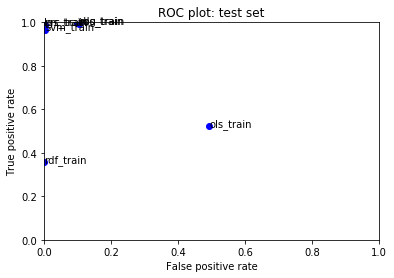

In [31]:
fits = [ols_performance_train, svm_performance_train, lgs_performance_train, nbs_performance_train, prc_performance_train, rdg_performance_train, rdf_performance_train]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

### looking at reviews based on their classification

Let's say we decide that Ordinary Least Squares (OLS) Regression is the best model for generalization. Let's take a look at some of the reviews and try to make a (subjective) determination of whether it's generalizing well. 

In [32]:
rdg_predictions = rdg.predict(X_train)

### let's look at some false positives:

In [33]:
# false positives

print("Examples of false positives:")

import random, time

for i in range(0, len(rdg_predictions)):
    if (rdg_predictions[i] == 1):
        if (X_raw_train.iloc[i]['any_toxic'] == 0):
            if (random.uniform(0, 1) < 0.05): # to print only 5% of the false positives
                print(i)
                print(X_raw_train.iloc[i]['comment_text'])
                print('* * * * * * * * * ')


Examples of false positives:
4
"

IT'S NOT LIKE EVERY METALLICA SONG IS USED AS A WWE THEME! I'd say the WWE is highly notable, and the fact that the admins are being pissants over one piece of information is appalling. ""OH NOES, CLUTTER!!!!11!""   "
* * * * * * * * * 
344
Unlike you I don't go deleting massive amounts of easily sourced critical info from the articles of subjects  I support. Carry on. -
* * * * * * * * * 
557
"
I saw that link before. I think its not a real document. Some part was taken from real document.
You can notice that on this link they use ""heart dispersion"" (""50 % windage and elevation dispersion""). But morons placed here http://en.wikipedia.org/wiki/SIG550 extreme spread."
* * * * * * * * * 
570
I removed it from the article because I supplied it on the image.  I am not violating anything, what is your issue why did you remove the rationale I supplied on the image page. I am going to report you to an aministrator if you don't stop with your destructive u

12461
probably without even reading them I found very rude. But I am sorry for insulting you.
* * * * * * * * * 
12550
Re 

Sorry, and you are?
* * * * * * * * * 
12785
what's with the weird conspiracy theory crap?
* * * * * * * * * 
12827
"

When you reply to a message in a talk page, you should use colons at the beggining of your lines. That indents the messages, so it'll look like an actual thread.

I started with one colon, so you should use two, then on my next reply I will use three, and so on.

""Happy hacking"" is something that Richard Stallman says. You don't have to be a programmer to hack.   "
* * * * * * * * * 
12978
"

Honestly, that was not ""threats of harassment"", maybe it sounds like it... but you don't know about the actual situation and what happened in the past. GVnayR is a very ""dangerous"" Wikipedian, I can deepen it. I'm editing Wikipedia since 2010 and I can say that he is the lamest, weirdest, most ""dangerous"", etc. In my opinion being blocked indefinitely

17242
Oh, and thanks for not biting my head off about it too. Not that any wonderful people would do that. *cough *cough
* * * * * * * * * 
17264
"
My pleasue. You deserve it and thank you for considering the review. It means a lot to me. Cheers!  Talk! .oOo. "
* * * * * * * * * 
17401
"
Who are you calling, a ""troll""? ;) 98.207.236.113  "
* * * * * * * * * 
17617
Hoffa Hoffa Hoffa! Buried in a brick! 

Why talk to elevators when no marbles are present?
* * * * * * * * * 
17637
devil horns? does the devil even have horns?
* * * * * * * * * 
17831
Hahahaha this article is awesome!!! Beat Strawberry!!! This is metscruft so bad!!Q! delete the fect section or I will!!!!
* * * * * * * * * 
17869
civil engineering 

 Love is sweet posion
* * * * * * * * * 
18148
Hey man, don't wanna sound stupid but what do you mean when you say CITE the refs?... I thought it was as simple as referencing facts?  Harish -
* * * * * * * * * 
18238
. You should be ashamed of yourself. Of course, you won't, be

27438
"

Oh, I know why. You see, I was pointing out to Linuxbeak that someone else hates him too. I just searched for ""Linuxbeak"" on Google, I didn't create that stuff.   "
* * * * * * * * * 
28217
"

Which means nothing so ever.  Thank you ever so much for adding your heap of useless to this conversation.  The point is just because some Otherkin site says ""We don't have CL"", it doesn't mean they don't.   "
* * * * * * * * * 
28275
"

 A kitten for you! 

i loved your articals

  
"
* * * * * * * * * 
28356
"
  

Your request to be unblocked has been granted for the following reason(s):
Thanks for showing your reason. You will never be blocked again.

Request handled by: 71.104.129.104  

 Unblocking administrator: Please check for active autoblocks on this user after accepting the unblock request."
* * * * * * * * * 
28608
Thank you ) - I am definitely planning to stick around.
* * * * * * * * * 
28974
"A piece of free advice from ""been there, done that"" ==

Take a week off.  


42998
"

 What about 
[==Strasbourg==
This ? Reverting to a poorer previous version pretending the additions and changes made are ""unneeded"" (he never ever added something useful to the article, remember). Please do at least warn him to stop one and for all to behave like a destructive fool. Thanks.  "
* * * * * * * * * 
43453
Why The Heck Is The First Thing Said, Literally, The First Thing Said About The Cavern Club About The Beatles.
* * * * * * * * * 
43499
excuse me. 

I am fixing that page, do not tell me that I'm vandalizing... if you would give me a chance.  I am creating the article by adding content and listing each character from the show, while replacing the redirect.
* * * * * * * * * 
43600
"

 Anon 

Hi. I was just reading your talk page and wondered what ""anonymous post removed"" was all about. Im not trying to be stupid, I'm just new. Thanks! 11:49, 10 Jan 2005 (UTC)"
* * * * * * * * * 
43652
less likeable messages here. Mark I know you are here posting your remarks.

54333
Ian's love for Oliver was ended tragically, but he still loves Oliver with all his heart.
* * * * * * * * * 
54545
"

Hacking
I'm not going to jump to coclusions and say it's you, but someone, possibly ""Curbs"" is trying to hack my computer.  Please stop!"
* * * * * * * * * 
54946
"Arguments like ""A friend of a friend said that she may be Panamanian..."" are ridiculous. "
* * * * * * * * * 
55136
"I would like you to explain here and now where did I use the words ""vandal"" or ""vandalism"" in the Revision history since you blocked me (last time I did was  21:08, 6 May 2009 more than a month ago)... Where did I Toddst1? You are now lying when accusing me here above. I haven't use ""the definition of WP:Vandalism"" when reverting lately. So, are you making use of your privileges as an administrator to harass me? 

"
* * * * * * * * * 
55256
Having fun?
Another of your racist admins just deleted my response again and u keep lying about me.
* * * * * * * * * 
55765
English telepat

67071
"

You say no transwomen believe this, it has been called a riddiculous straw man.  Yet if one goes to tsroadmap.com and/or lynnconway.com and googles (in the search boxes you would see on their pages) ""brain sex"" they will get many hits.    Read ""The theory that prenatally established brain and CNS   structures determine innate gender feelings and gender identity.""  ""It appears that if those brain and CNS structures are masculinized   in early pregnancy by hormones in the fetus, then the child will   have male percepts and a male gender identity, independent of   whether the genes or genitalia are male. If those structures   are not masculinized in early pregnancy, the child will have   a female percepts and a female gender identity, again independent   of the genes or genitalia. As in the case of intersex infants   having ambiguous genitalia, there are undoubtedly many degrees   of cross-gendering of brain and CNS structures, so that while   some infants are completely cro

79593
"

May you please put your money where your mouth is and provide VERSES for the ALL the names I indicated - if you can't even do it for five names, your contention that ""All the other grandsons are mentioned elsewhere"" seems to be hot air.  (talk) "
* * * * * * * * * 
79658
"

""I wanted you to know that I reformatted your post, changing the bold text into a boxed-text version, while not changing any of the text. Bold text is a pain in the arse to read. I hope you aren;t offended by the change, and please believe that none is intended. - Arcayne (cast a spell) ""

Not a problem, Lucy. )"
* * * * * * * * * 
79710
"

 Hey jerkwad 
thanks f0r deleting my article 0n ""Lauren Felts"".  Y0u pretty much had n0 valid reas0n 0f d0ing that.  Please st0p, kthnx."
* * * * * * * * * 
80186
Shelly, A. 

Next thing we know you'll be taking credit for her (uncited) murder.  99.164.68.102
* * * * * * * * * 
80188
One of the videos i linked to did answer that, but was censored together with the 

93470
3PO
I put another response on John Bowlby if you had a mo. Or half a mo come to that.  barley
* * * * * * * * * 
94093
GDPPP nominal UK etc
Y'know Keizuko I'd swear those guys don't even understand what that PPP thingy is. Sheesh.
* * * * * * * * * 
94097
"
Heh. I don't really care. I've made some good contributions to wiki. I fixed the unfixable ""unsolved problems in philosophy"" article, the bio for the poet Howard Nemerov, and little fixes to philosophy and math articles. Meanwhile, this clown goes around censoring any negative information about Topalov, regardless of how factually accurate, and I get banned for calling him an idiot? If they want to ban me, then so be it. Let them ban me for life for all I care. I'm happy to mock their ""decision"" and the inarticulate schlepp that is Dionyseus. This is the author of the ""pseudo-penis"" article, who's constantly embroiled in arbitration on some topic or another. The guy whose chief contribution to Wikipedia has been individu

106983
Er, who decided that that was a policy, and when? 88.104.27.75
* * * * * * * * * 
107235
YES. I understand.

YES, YES, YES
* * * * * * * * * 
107433
i clearly think you should stop to 

you defending a mstement you do not know or threating and defending some kid for saying hee hates black people and hispanics i do not respect that
* * * * * * * * * 
107892
This talk is useless. Title canot be changed. Why talk then? I wish you a white phosfor. -
* * * * * * * * * 
108022
You have NOT heeded your last warning.  A Block of this ip is in progress.   Have a nice day )
* * * * * * * * * 
108414
We are going to wait 24 hours for all of the debates above to be incorporated.  Celebrities, Mom & baby, the richest European.  If you wont add much or some of that, trust us all of Agro will be removed.  This is absurd.  Govern yourself accordingly.
* * * * * * * * * 
108490
Urgent complain - Wikipedia 

Answer given by you shows that you and whoever associated with WikipediaBold text don't c

121591
Nice try 

I'm back. Enjoy banning me all night because it won't stop. LOL.
* * * * * * * * * 
122312
Fluence, until you understand that your contributions are of an extremely low quality and learn how to fix them, you will simply be an annoyance to Wikipedia. All of your updates and articles are useless fan cruft. You waste time by nominating it all to be displayed on the front page, and you are are abusive to people who offer criticism, even of the polite constructive sort. You should perhaps focus your attentions on making a Keane fan site, and stop trying to turn Wikipedia into one. Nobody likes Keane, Fluence. They are terrible.
* * * * * * * * * 
122470
Nickname 

Hey, I like that...Gee. You'll be my Gee.
* * * * * * * * * 
122508
? I never want to refer to this user anymore.
* * * * * * * * * 
122835
Attack is not personal if Avitar hides behind Wiki like a little manboy (WANKER)..
* * * * * * * * * 
122882
Ch ch ch ch changes
I'm converting this list to an actual list (i

---

# <span style="color:red">WARNING: Don't look at test set performance too much!</span>

---

The following cells show performance on your test set. Do not look at this too often! 

# Look at performance on the test set

### MODEL: ordinary least squares

In [34]:
ols_performance_test = BinaryClassificationPerformance(ols.predict(X_test), y_test, 'ols_test')
ols_performance_test.compute_measures()
print(ols_performance_test.performance_measures)

{'Pos': 3215, 'Neg': 28700, 'TP': 1675, 'TN': 14568, 'FP': 14132, 'FN': 1540, 'Accuracy': 0.5089456368478772, 'Precision': 0.10596571139368634, 'Recall': 0.52099533437014, 'desc': 'ols_test'}


### MODEL: SVM, linear

In [35]:
svm_performance_test = BinaryClassificationPerformance(svm.predict(X_test), y_test, 'svm_test')
svm_performance_test.compute_measures()
print(svm_performance_test.performance_measures)

{'Pos': 3215, 'Neg': 28700, 'TP': 2067, 'TN': 27717, 'FP': 983, 'FN': 1148, 'Accuracy': 0.9332288892370358, 'Precision': 0.6777049180327869, 'Recall': 0.6429237947122861, 'desc': 'svm_test'}


### MODEL: logistic regression

In [36]:
lgs_performance_test = BinaryClassificationPerformance(lgs.predict(X_test), y_test, 'lgs_test')
lgs_performance_test.compute_measures()
print(lgs_performance_test.performance_measures)

{'Pos': 3215, 'Neg': 28700, 'TP': 2040, 'TN': 27528, 'FP': 1172, 'FN': 1175, 'Accuracy': 0.9264609117969607, 'Precision': 0.635118306351183, 'Recall': 0.6345256609642301, 'desc': 'lgs_test'}


### MODEL: Naive Bayes

In [37]:
nbs_performance_test = BinaryClassificationPerformance(nbs.predict(X_test), y_test, 'nbs_test')
nbs_performance_test.compute_measures()
print(nbs_performance_test.performance_measures)

{'Pos': 3215, 'Neg': 28700, 'TP': 1858, 'TN': 25872, 'FP': 2828, 'FN': 1357, 'Accuracy': 0.8688704370985431, 'Precision': 0.39650021340162184, 'Recall': 0.5779160186625194, 'desc': 'nbs_test'}


### MODEL: Perceptron

In [38]:
prc_performance_test = BinaryClassificationPerformance(prc.predict(X_test), y_test, 'prc_test')
prc_performance_test.compute_measures()
print(prc_performance_test.performance_measures)

{'Pos': 3215, 'Neg': 28700, 'TP': 2036, 'TN': 27582, 'FP': 1118, 'FN': 1179, 'Accuracy': 0.9280275732414225, 'Precision': 0.6455294863665187, 'Recall': 0.6332814930015552, 'desc': 'prc_test'}


### MODEL: Ridge Regression Classifier

In [21]:
rdg_performance_test = BinaryClassificationPerformance(rdg.predict(X_test), y_test, 'rdg_test')
rdg_performance_test.compute_measures()
print(rdg_performance_test.performance_measures)

{'Pos': 3215, 'Neg': 28700, 'TP': 2976, 'TN': 23661, 'FP': 5039, 'FN': 239, 'Accuracy': 0.834623217922607, 'Precision': 0.37130380536494073, 'Recall': 0.9256609642301711, 'desc': 'rdg_test'}


### MODEL: Random Forest Classifier

In [39]:
rdf_performance_test = BinaryClassificationPerformance(rdf.predict(X_test), y_test, 'rdf_test')
rdf_performance_test.compute_measures()
print(rdf_performance_test.performance_measures)

{'Pos': 3215, 'Neg': 28700, 'TP': 555, 'TN': 28688, 'FP': 12, 'FN': 2660, 'Accuracy': 0.9162776124079587, 'Precision': 0.9788359788359788, 'Recall': 0.17262830482115085, 'desc': 'rdf_test'}


### ROC plot to compare performance of various models and fits

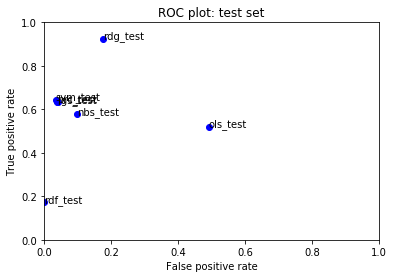

In [40]:
fits = [ols_performance_test, svm_performance_test, lgs_performance_test, nbs_performance_test, prc_performance_test, rdg_performance_test, rdf_performance_test]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

---

# <span style="color:red">SUBMISSION</span>

---

In [23]:
# read in test data for submission
# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
raw_data, X_test_submission = process_raw_data(fn='data/toxiccomments_test.csv', my_random_seed=97, test=True)
print("Number of rows in the submission test set (should be 153,164): ")

toxic_data is: <class 'pandas.core.frame.DataFrame'>
toxic_data has 153164 rows and 2 columns 

the data types for each of the columns in toxic_data:
id              object
comment_text    object
dtype: object 

the first 10 rows in toxic_data:
                 id                                       comment_text
0  00001cee341fdb12  Yo bitch Ja Rule is more succesful then you'll...
1  0000247867823ef7  == From RfC == \n\n The title is fine as it is...
2  00013b17ad220c46  " \n\n == Sources == \n\n * Zawe Ashton on Lap...
3  00017563c3f7919a  :If you have a look back at the source, the in...
4  00017695ad8997eb          I don't anonymously edit articles at all.
Look at a few rows of the new quantitative features: 
    exclam_count  uppercase  questions
0              0          0          0
1              0          0          0
2              0          0          0
3              0          0          0
4              0          0          0
..           ...        ...        ...
95

---

Choose a <span style="color:red">*single*</span> model for your submission. In this code, I am choosing the Ordinary Least Squares model fit, which is in the `ols` object. But you should choose the model that is performing the best for you! 

In [24]:
# store the id from the raw data
my_submission = pd.DataFrame(raw_data["id"])
# concatenate predictions to the id
my_submission["prediction"] = rdg.predict(X_test_submission)
# look at the proportion of positive predictions
print(my_submission['prediction'].mean())

0.4181530908046277


In [25]:
raw_data.head()

,id,comment_text,exclam_count,uppercase,questions
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...,0,0,0
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...,0,0,0
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap...",0,0,0
3,00017563c3f7919a,":If you have a look back at the source, the in...",0,0,0
4,00017695ad8997eb,I don't anonymously edit articles at all.,0,0,0


In [26]:
my_submission.head()

,id,prediction
0,00001cee341fdb12,True
1,0000247867823ef7,True
2,00013b17ad220c46,False
3,00017563c3f7919a,True
4,00017695ad8997eb,True


In [27]:
my_submission.shape

(153164, 2)

In [28]:
# export submission file as pdf
# CHANGE FILE PATH: 
my_submission.to_csv('data/toxiccomments_submission.csv', index=False)

# Submit to Canvas: 1) the CSV file that was written in the previous cell and 2) the url to the repository (GitHub or other) that contains your code and documentation